In [41]:
import pandas as pd
from google.colab import drive

# 드라이브 마운트
drive.mount('/content/drive')

# 심부전 데이터셋 Read
data = pd.read_csv('/content/drive/My Drive/data/heart.csv')
print("데이터 rows * columns: {}".format(data.shape[:]))
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
데이터 rows * columns: (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [42]:
# 데이터셋 900 rows 및 7개 columns 사용
X = data.loc[:899, ['Age', 'ChestPainType', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina']]
y = data.loc[:899, ['HeartDisease']]

print("데이터 rows * columns: {}".format(X.shape[:]))
X.head()

데이터 rows * columns: (900, 7)


,Age,ChestPainType,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina
0,40,ATA,289,0,Normal,172,N
1,49,NAP,180,0,Normal,156,N
2,37,ATA,283,0,ST,98,N
3,48,ASY,214,0,Normal,108,Y
4,54,NAP,195,0,Normal,122,N


In [43]:
y.head()

,HeartDisease
0,0
1,1
2,0
3,1
4,0


In [44]:
# 문자열 값을 변환
# 흉통 유형 (ASY[0]:무증상, NAP[1]: 비협심증, ATA[2]: 비정형 협심증, TA[3]: 전형적인 협심증) 변환
listChestPainType = []
for gt in X['ChestPainType']:
  if gt == 'ASY':
    listChestPainType.append(0)
  elif gt == 'NAP':
    listChestPainType.append(1)
  elif gt == 'ATA':
    listChestPainType.append(2)
  elif gt == 'TA':
    listChestPainType.append(3)
  else:
    listChestPainType.append(gt)
# ChestPainType 칼럼 삭제 후 listChestPainType 칼럼으로 대체
X.drop(['ChestPainType'], axis=1, inplace=True)
X.insert(1, 'ChestPainType', listChestPainType, allow_duplicates=False)

# RestingECG (Normal[0], ST[1], LVH[2]) 변환
listRestingECG = []
for gt in X['RestingECG']:
  if gt == 'Normal':
    listRestingECG.append(0)
  elif gt == 'ST':
    listRestingECG.append(1)
  elif gt == 'LVH':
    listRestingECG.append(2)
  else:
    listRestingECG.append(gt)
# RestingECG 칼럼 삭제 후 listRestingECG 칼럼으로 대체
X.drop(['RestingECG'], axis=1, inplace=True)
X.insert(4, 'RestingECG', listRestingECG, allow_duplicates=False)

# Exercise Angina 칼럼 (N[0], Y[1]) 변환
listExerciseAngina = []
for gt in X['ExerciseAngina']:
  if gt == 'Y':
    listExerciseAngina.append(1)
  elif gt == 'N':
    listExerciseAngina.append(0)
  else:
    listExerciseAngina.append(gt)
# Exercise Angina 칼럼 대체
X.drop(['ExerciseAngina'], axis=1, inplace=True)
X.insert(6, 'ExerciseAngina', listExerciseAngina, allow_duplicates=False)

X.head()

,Age,ChestPainType,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina
0,40,2,289,0,0,172,0
1,49,1,180,0,0,156,0
2,37,2,283,0,1,98,0
3,48,0,214,0,0,108,1
4,54,1,195,0,0,122,0


In [45]:
# 훈련셋과 시험셋 분리
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import column_or_1d
y = column_or_1d(y, warn=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


In [46]:
# SVM을 통한 분류 (파라미터 튜닝 X)
from sklearn import svm
from sklearn.metrics import accuracy_score

svm_clf = svm.SVC(kernel='rbf')
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)
print('accuracy: {:.4f}'.format(accuracy_score(y_test, svm_pred)))


accuracy: 0.7333


In [47]:
# SVM (GridSearchCV) 를 통한 최적의 하이퍼 파라미터 도출하여 학습
from sklearn.model_selection import GridSearchCV

svm_grid_clf = svm.SVC(kernel='rbf')
parameters = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 30, 50],
    'gamma' : [0.001, 0.01, 0.1, 1, 10, 30, 50]
}

# 최적의 하이퍼파라미터 도출하여 학습
grid_svm = GridSearchCV(svm_grid_clf, param_grid=parameters, cv=5)
grid_svm.fit(X_train, y_train)

# 평균 시험정확도 출력
grid_result_pd = pd.DataFrame(grid_svm.cv_results_['params'])
grid_result_pd['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
grid_result_pd.sort_values(by='mean_test_score', ascending=False).head()

,C,gamma,mean_test_score
35,30.0,0.001,0.748611
42,50.0,0.001,0.747222
28,10.0,0.001,0.737500
21,1.0,0.001,0.720833
14,0.1,0.001,0.693056


In [48]:
# 최적 하이퍼파라미터를 활용한 시험 정확도
svm_grid_clf_pred = grid_svm.predict(X_test)
print('accuracy : {:.4f}'.format(accuracy_score(y_test, svm_grid_clf_pred)))

accuracy : 0.7444


In [49]:
# 의사결정트리
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 의사결정트리 (파라미터 튜닝 X)
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

tree_pred = tree_clf.predict(X_test)
tree_accuracy = '{:.4f}'.format(accuracy_score(y_test, tree_pred))
print('의사결정트리(파라미터X) accuracy : ' + tree_accuracy)

# 의사결정트리 (파라미터 튜닝 O)
tree_param_clf = DecisionTreeClassifier(
    max_depth=3, min_samples_split=3, random_state=15)
tree_param_clf.fit(X_train, y_train)

tree_param_pred = tree_param_clf.predict(X_test)
tree_param_accuracy = '{:.4f}'.format(accuracy_score(y_test, tree_param_pred))
print('의사결정트리(파라미터O) accuracy : ' + tree_param_accuracy)

의사결정트리(파라미터X) accuracy : 0.7444
의사결정트리(파라미터O) accuracy : 0.8222


In [50]:
# 랜덤포레스트
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd

# 파라미터 없이 학습
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

rf_pred = rf_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, rf_pred)
print('랜덤포레스트(파라미터X) accuracy : {:.4f}'.format(accuracy_rf))

랜덤포레스트(파라미터X) accuracy : 0.8222


In [51]:
# 파라미터를 사용하여 학습
rf_param_grid = {
    'n_estimators' : [110, 120, 130],
    'min_samples_leaf' : [3, 5, 7],
    'min_samples_split' : [15, 20, 30]
}

# 최적의 하이퍼 파라미터 찾기
rf_param_clf = RandomForestClassifier()
rf_grid_clf = GridSearchCV(rf_param_clf, param_grid=rf_param_grid, scoring='accuracy', n_jobs=1)
rf_grid_clf.fit(X_train, y_train)

# 최적 하이퍼 파라미터 Top 5 출력
grid_rf_result_pd = pd.DataFrame(rf_grid_clf.cv_results_['params'])
grid_rf_result_pd['mean_test_score'] = rf_grid_clf.cv_results_['mean_test_score']
grid_rf_result_pd.sort_values(by='mean_test_score', ascending=False).head()

,min_samples_leaf,min_samples_split,n_estimators,mean_test_score
21,7,20,110,0.822222
5,3,20,130,0.820833
20,7,15,130,0.819444
15,5,30,110,0.819444
1,3,15,120,0.819444


In [52]:
# 시험셋 정확도 측정
rf_param_pred = rf_grid_clf.predict(X_test)
accuracy_rf_param = accuracy_score(y_test, rf_param_pred)
print('랜덤포레스트(파라미터O) accuracy : {:.4f}'.format(accuracy_rf_param))

랜덤포레스트(파라미터O) accuracy : 0.8056


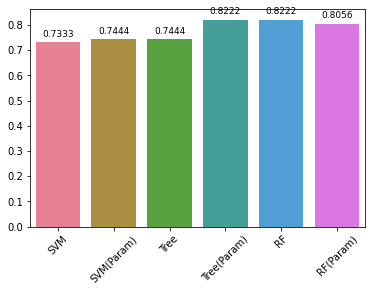

In [53]:
# 정확도 비교 그래프
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, ax = plt.subplots(figsize=(6,4))
x_graph_data = np.arange(6)
y_graph_data = [
                accuracy_score(y_test, svm_pred), 
                accuracy_score(y_test, svm_grid_clf_pred), 
                accuracy_score(y_test, tree_pred),
                accuracy_score(y_test, tree_param_pred),
                accuracy_score(y_test, rf_pred),
                accuracy_score(y_test, rf_param_pred)]
g = sns.barplot(ax=ax, palette='husl', x=x_graph_data, y=y_graph_data)
g.set_xticklabels(['SVM', 'SVM(Param)', 'Tree', 
                   'Tree(Param)', 'RF', 'RF(Param)'], rotation=45)
for p in g.patches:
  g.annotate(format(p.get_height(), '.4f'), 
             (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', 
             xytext=(0, 8), textcoords='offset points', size=9)
plt.show()

In [54]:
# 재현율
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# Confusion Matrix 계산
svm_fusion_matrix         = confusion_matrix(y_test, svm_pred)
svm_param_fusion_matrix   = confusion_matrix(y_test, svm_grid_clf_pred)
tree_fusion_matrix        = confusion_matrix(y_test, tree_pred)
tree_param_fusion_matrix  = confusion_matrix(y_test, tree_param_pred)
rf_fusion_matrix          = confusion_matrix(y_test, rf_pred)
rf_param_fusion_matrix    = confusion_matrix(y_test, rf_param_pred)

# SVM TN, TP 재현율 계산
svm_recall_tn       = (svm_fusion_matrix[0, 0] / (svm_fusion_matrix[0, 0] + svm_fusion_matrix[0, 1])) * 100
svm_recall_tp       = (svm_fusion_matrix[1, 1] / (svm_fusion_matrix[1, 0] + svm_fusion_matrix[1, 1])) * 100
svm_param_recall_tn = (svm_param_fusion_matrix[0, 0] / (svm_param_fusion_matrix[0, 0] + svm_param_fusion_matrix[0, 1])) * 100
svm_param_recall_tp = (svm_param_fusion_matrix[1, 1] / (svm_param_fusion_matrix[1, 0] + svm_param_fusion_matrix[1, 1])) * 100

# 의사결정트리 TN, TP 재현율 계산
tree_recall_tn        = (tree_fusion_matrix[0, 0] / (tree_fusion_matrix[0, 0] + tree_fusion_matrix[0, 1])) * 100
tree_recall_tp        = (tree_fusion_matrix[1, 1] / (tree_fusion_matrix[1, 0] + tree_fusion_matrix[1, 1])) * 100
tree_param_recall_tn  = (tree_param_fusion_matrix[0, 0] / (tree_param_fusion_matrix[0, 0] + tree_param_fusion_matrix[0, 1])) * 100
tree_param_recall_tp  = (tree_param_fusion_matrix[1, 1] / (tree_param_fusion_matrix[1, 0] + tree_param_fusion_matrix[1, 1])) * 100

# 랜덤포레스트 TN, TP 재현율 계산
rf_recall_tn        = (rf_fusion_matrix[0, 0] / (rf_fusion_matrix[0, 0] + rf_fusion_matrix[0, 1])) * 100
rf_recall_tp        = (rf_fusion_matrix[1, 1] / (rf_fusion_matrix[1, 0] + rf_fusion_matrix[1, 1])) * 100
rf_param_recall_tn  = (rf_param_fusion_matrix[0, 0] / (rf_param_fusion_matrix[0, 0] + rf_param_fusion_matrix[0, 1])) * 100
rf_param_recall_tp  = (rf_param_fusion_matrix[1, 1] / (rf_param_fusion_matrix[1, 0] + rf_param_fusion_matrix[1, 1])) * 100

list_tn_recall = [svm_recall_tn, svm_param_recall_tn, tree_recall_tn, 
                tree_param_recall_tn, rf_recall_tn, rf_param_recall_tn]
list_tp_recall = [svm_recall_tp, svm_param_recall_tp, tree_recall_tp,
                tree_param_recall_tp, rf_recall_tp, rf_param_recall_tp]

list_str_accuracy  = [] # 정확도 문자열 리스트
list_str_recall_tn = [] # TN 재현율 문자열 리스트
list_str_recall_tp = [] # TP 재현율 문자열 리스트

for i in range(0, 6):
  list_str_accuracy.append('{:.2f}%'.format(y_graph_data[i] * 100))
  list_str_recall_tn.append('{:.2f}%'.format(list_tn_recall[i]))
  list_str_recall_tp.append('{:.2f}%'.format(list_tp_recall[i]))

# 재현율 표 생성
recall_table = pd.DataFrame({
    '알고리즘': ['SVM', 'SVM(Param)', 'Tree', 'Tree(Param)', 'RF', 'RF(Param)'],
    'TN 재현율' : list_str_recall_tn,
    'TP 재현율' : list_str_recall_tp,
    '정확도' : list_str_accuracy
})
recall_table.head(6)

,알고리즘,TN 재현율,TP 재현율,정확도
0,SVM,64.56%,80.20%,73.33%
1,SVM(Param),72.15%,76.24%,74.44%
2,Tree,72.15%,76.24%,74.44%
3,Tree(Param),88.61%,77.23%,82.22%
4,RF,81.01%,83.17%,82.22%
5,RF(Param),77.22%,83.17%,80.56%
